In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ada/new_features_financial_habit.csv")

In [3]:
df.head()

,age,gender,monthly_income_range,total_monthly_spending,food_spending,transport_spending,entertainment_spending,shopping_spending,rent_spending,other_spending,...,food_spending_share,transport_spending_share,entertainment_spending_share,shopping_spending_share,rent_spending_share,other_spending_share,discretionary_spending,discretionary_ratio,savings_intensity,savings_gap_ratio
0,22,Мужской,100 000 – 200 000,150000,100000,3000,40000.0,10000.0,0,0.0,...,0.653595,0.019608,0.261438,0.065359,0.000000,0.000000,50000.0,0.326797,0.130719,0.133332
1,23,Женский,300 000 – 500 000,450000,0,10000,20000.0,0.0,155000,0.0,...,0.000000,0.054054,0.108108,0.000000,0.837838,0.000000,20000.0,0.108108,0.000000,0.000000
2,22,Мужской,300 000 – 500 000,200000,100000,2000,50000.0,50000.0,120000,30000.0,...,0.284091,0.005682,0.142045,0.142045,0.340909,0.085227,100000.0,0.284091,0.142045,0.249999
3,24,Женский,300 000 – 500 000,390000,110000,17500,50000.0,65000.0,0,300000.0,...,0.202765,0.032258,0.092166,0.119816,0.000000,0.552995,115000.0,0.211982,0.230415,0.320512
4,23,Женский,300 000 – 500 000,300000,100000,20000,30000.0,100000.0,0,40000.0,...,0.344828,0.068966,0.103448,0.344828,0.000000,0.137931,130000.0,0.448276,0.172414,0.166666


In [4]:
cluster_features = [
    "discretionary_ratio",          # импульсивность расходов
    "savings_intensity",             # интенсивность накоплений
    "impulse_purchase_frequency",    # частота импульсивных покупок
    "saving_difficulty_score",       # субъективная сложность
    "rent_spending_share"            # структурная нагрузка
]

In [5]:
X = df[cluster_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X.isna().sum()

,0
discretionary_ratio,0
savings_intensity,0
impulse_purchase_frequency,0
saving_difficulty_score,0
rent_spending_share,0


In [7]:
sil_scores = {}

for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

sil_scores

{2: np.float64(0.23026951378833824),
 3: np.float64(0.212072276562649),
 4: np.float64(0.22740576503566703),
 5: np.float64(0.22945274288667705)}

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

In [9]:
cluster_summary = df.groupby("cluster")[cluster_features].mean()
cluster_summary

,discretionary_ratio,savings_intensity,impulse_purchase_frequency,saving_difficulty_score,rent_spending_share
cluster,,,,,
0,0.290409,0.300169,1.931034,1.931034,0.119887
1,0.494216,0.164712,3.320000,3.200000,0.017629
2,0.191257,0.106575,3.160000,4.000000,0.308384
3,0.203125,6.250000,3.000000,1.000000,0.625000


In [10]:
cluster_sizes_pct = df["cluster"].value_counts(normalize=True).sort_index() * 100
cluster_sizes_pct

,proportion
cluster,
0,36.25
1,31.25
2,31.25
3,1.25


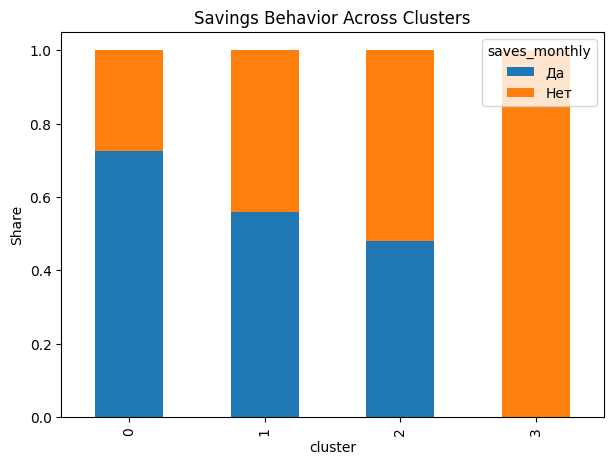

In [11]:
saves_cluster = (
    df.groupby("cluster")["saves_monthly"]
      .value_counts(normalize=True)
      .unstack()
)

saves_cluster.plot(
    kind="bar",
    stacked=True,
    figsize=(7,5)
)
plt.title("Savings Behavior Across Clusters")
plt.ylabel("Share")
plt.show()


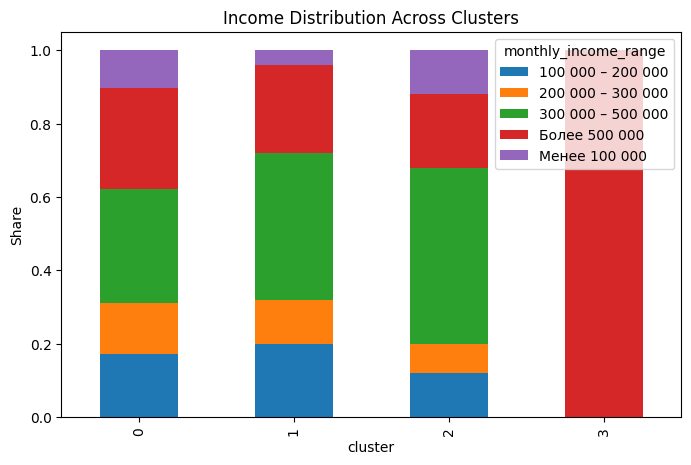

In [12]:
income_cluster = (
    df.groupby("cluster")["monthly_income_range"]
      .value_counts(normalize=True)
      .unstack()
)

income_cluster.plot(
    kind="bar",
    stacked=True,
    figsize=(8,5)
)
plt.title("Income Distribution Across Clusters")
plt.ylabel("Share")
plt.show()

In [13]:
radar_features = [
    "savings_intensity",     # реальное накопление
    "discretionary_ratio",      # импульсивность расходов
    "impulse_purchase_frequency",    # частота импульсивных покупок
    "saving_difficulty_score",   # субъективная сложность
    "rent_spending_share"   # структурная нагрузка
]

In [14]:
cluster_radar = df.groupby("cluster")[radar_features].mean()

# Normalize for radar (0–1)
cluster_radar_norm = (
    cluster_radar - cluster_radar.min()
) / (cluster_radar.max() - cluster_radar.min())

In [15]:
def plot_radar(data, title):
    labels = data.columns
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for idx in data.index:
        values = data.loc[idx].tolist()
        values += values[:1]
        ax.plot(angles, values, label=f"Cluster {idx}")
        ax.fill(angles, values, alpha=0.15)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)

    plt.title(title, size=14, pad=30)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

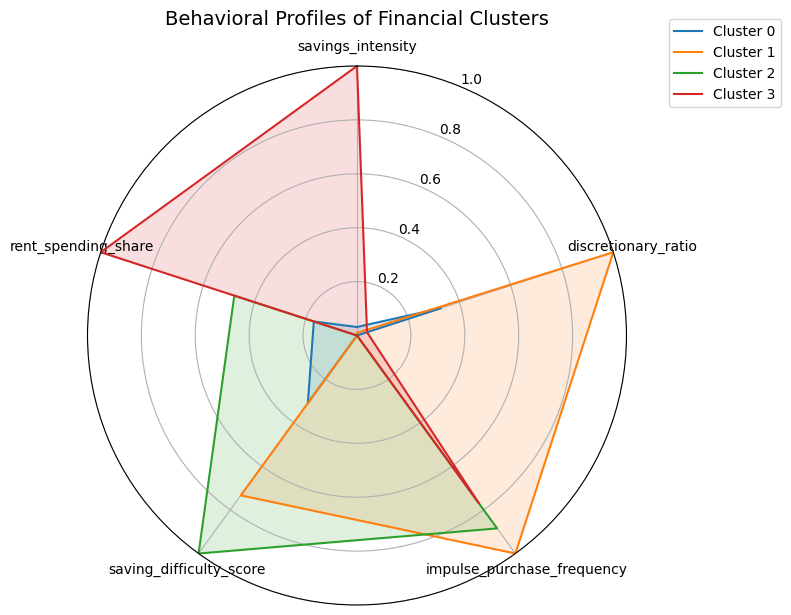

In [16]:
plot_radar(
    cluster_radar_norm,
    title="Behavioral Profiles of Financial Clusters"
)

In [17]:
df["spending_variability"] = (
    df[["food_spending", "transport_spending",
        "entertainment_spending", "shopping_spending",
        "rent_spending", "other_spending"]]
    .std(axis=1)
)

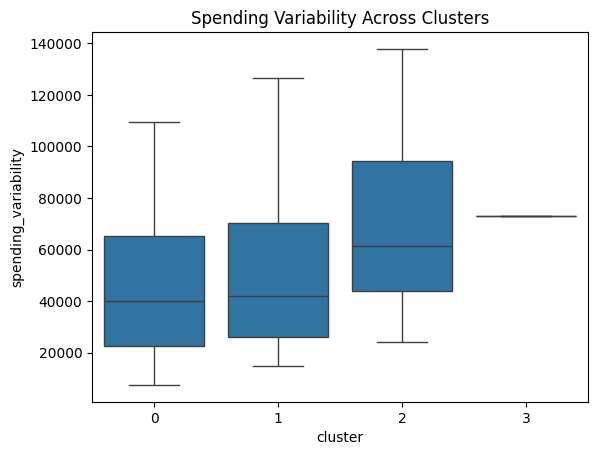

In [18]:
sns.boxplot(x="cluster", y="spending_variability", data=df, showfliers=False)
plt.title("Spending Variability Across Clusters")
plt.show()

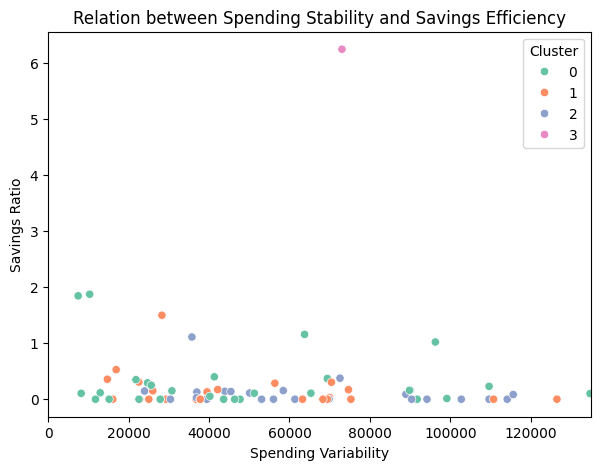

In [19]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="spending_variability",
    y="savings_intensity",
    hue="cluster",
    data=df,
    palette="Set2"
)

plt.title("Relation between Spending Stability and Savings Efficiency")
plt.xlabel("Spending Variability")
plt.ylabel("Savings Ratio")
plt.legend(title="Cluster")
plt.xlim(0, df["spending_variability"].quantile(0.95))
plt.show()

In [20]:
def get_cluster_recommendation(cluster):
    recommendations = {
          0: [
              "Set strict discretionary spending limits",
              "Use impulse-purchase blockers (24h rule)",
              "Track expenses daily using budgeting apps"
          ],
          1: [
              "Automate savings transfers",
              "Set long-term financial goals",
              "Consider low-risk investments"
          ],
          2: [
              "Focus on reducing fixed costs",
              "Build an emergency fund",
              "Start with small, consistent savings"
          ],
          3: [
              "Re-evaluate housing costs",
              "Balance rent burden with savings goals",
              "Optimize fixed vs variable expenses"
          ]
      }

    return recommendations.get(cluster, "No recommendation available")

In [21]:
def recommend_from_console(df):
    try:
        user_input = input("Enter user ID (row index): ")
        user_id = int(user_input)

        if user_id not in df.index:
            print("User not found.")
            return

        user = df.loc[user_id]
        cluster = int(user["cluster"])

        print("\nUSER PROFILE")
        print("----------------------------")
        print(f"User ID: {user_id}")
        print(f"Cluster: {cluster}")
        print(f"Savings intensity: {round(user['savings_intensity'], 2)}")
        print(f"Impulse purchases: {user['impulse_purchase_frequency']}")
        print(f"Rent spending share: {round(user['rent_spending_share'], 2)}")

        print("\n RECOMMENDATION")
        print("----------------------------")
        print(get_cluster_recommendation(cluster))

    except ValueError:
        print("Please enter a valid numeric ID.")

In [22]:
recommend_from_console(df)


Enter user ID (row index): 14

USER PROFILE
----------------------------
User ID: 14
Cluster: 0
Savings intensity: 0.0
Impulse purchases: 3
Rent spending share: 0.0

 RECOMMENDATION
----------------------------
['Set strict discretionary spending limits', 'Use impulse-purchase blockers (24h rule)', 'Track expenses daily using budgeting apps']
